# notebook imagenette
The basis is kaiming initialization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.modelmanager import *
from lib.model import *
from lib.callbacks import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## Imagenette data

In [4]:
#path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path = Path("/Users/kasparlund/.fastai/data/imagenette-160")

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

images = ImageList.from_files(path, tfms=tfms)
#sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
#ll = label_by_func(sd, parent_labeler)
#sd = SplitData.split_by_func(images, splitter); 

#split data based on the foldername of the grandparent
splitter    = partial(grandparent_splitter, valid_name='val')
sd          = SplitData.split_by_func(images, splitter); 
data = label_train_valid_data(sd, parent_labeler, proc_y=CategoryProcessor())

train_dl,valid_dl = ( DataLoader(data.train, batch_size=bs,   num_workers=4, shuffle=True),
                      DataLoader(data.valid, batch_size=bs*2, num_workers=4))
databunch = DataBunch(train_dl, valid_dl, c_in=3, c_out=max(data.train.y)+1)

#train_dl,valid_dl = ( DataLoader(ll.train, batch_size=bs,   num_workers=4, shuffle=True),
#                      DataLoader(ll.valid, batch_size=bs*2, num_workers=4))
#data = DataBunch(train_dl, valid_dl, c_in=3, c_out=max(ll.train.y)+1)
#print(len(train_dl))

In [6]:
#layers_sizes = [32,64,128,256,512]
layers_sizes = [64,64,128,256]
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#        partial(ParamScheduler, 'lr', sched),
        partial(BatchTransformXCallback, norm_imagenette),
        partial(MixUp,α=0.4),
        
        #CudaCallback,
        ProgressCallback,
       ]
cbfs = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy])]
cbfs_lr_Finder = cbfs_base.copy() + [LR_Finder]

## steppers=[sgd_step]

In [7]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=nn.ReLU )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)

learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(1, opt=SGD(sched,max_lr=0.1), cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.177834,0.233209,1.914231,0.356000,02:28


CPU times: user 4min 54s, sys: 2min 5s, total: 6min 59s
Wall time: 2min 28s


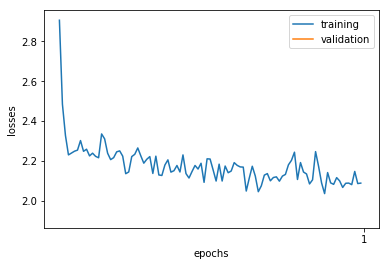

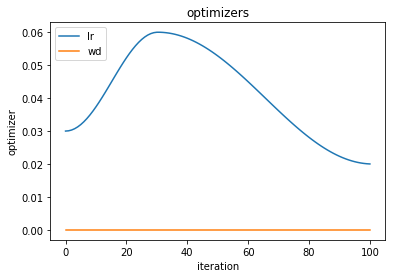

(None, None)

In [8]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()


## steppers=[weight_decay, sgd_step]

In [9]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=nn.ReLU )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)

learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
#print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
%time learn.fit(1, opt=SGD(sched,max_lr=0.1, max_wd=1e-4), cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.190370,0.230262,1.958056,0.318000,02:01


CPU times: user 4min 45s, sys: 2min 23s, total: 7min 8s
Wall time: 2min 1s


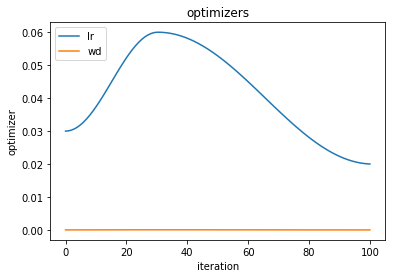

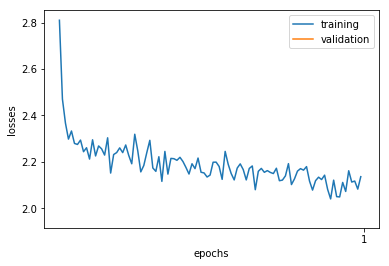

(None, None)

In [10]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [11]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=nn.ReLU )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)

learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(1, opt=SGD_Momentum(sched,max_lr=0.08, moms=(0.85,0.95), max_wd=2e-4 ), cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.241458,0.202963,1.999122,0.300000,02:00


CPU times: user 4min 44s, sys: 2min 25s, total: 7min 10s
Wall time: 2min


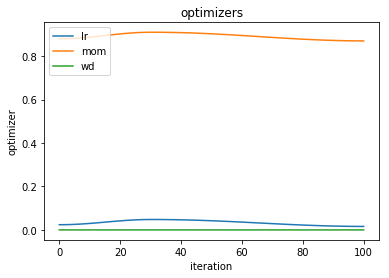

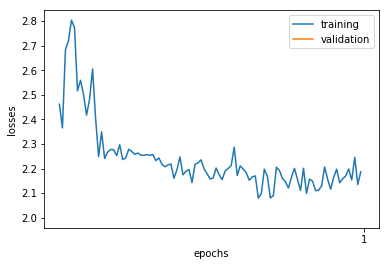

(None, None)

In [12]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam: steppers=[adam_step]

In [13]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=nn.ReLU )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)
                        
learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(1, opt=Adam(sched,max_lr=3e-4, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.152022,0.245075,1.845341,0.412000,02:17


CPU times: user 5min 4s, sys: 2min 33s, total: 7min 38s
Wall time: 2min 17s


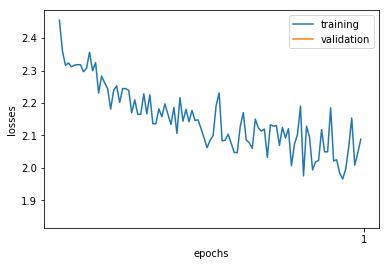

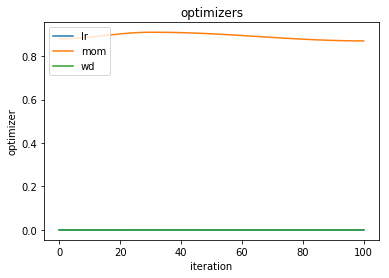

(None, None)

In [14]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## LAMB: steppers=[lamb_step]

In [15]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=nn.ReLU )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)
                        
learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(3, opt=LAMB(sched,max_lr=3e-3, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.138530,0.256553,1.778198,0.400000,02:15
1,1.947423,0.377385,1.552100,0.488000,02:12
2,1.829616,0.454708,1.417529,0.556000,02:20


CPU times: user 15min 7s, sys: 7min 52s, total: 22min 59s
Wall time: 6min 47s


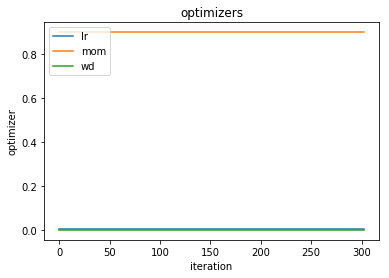

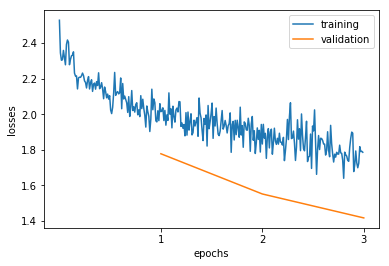

(None, None)

In [16]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=17),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam with hooks

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.175468,0.237009,1.917488,0.376000,03:07


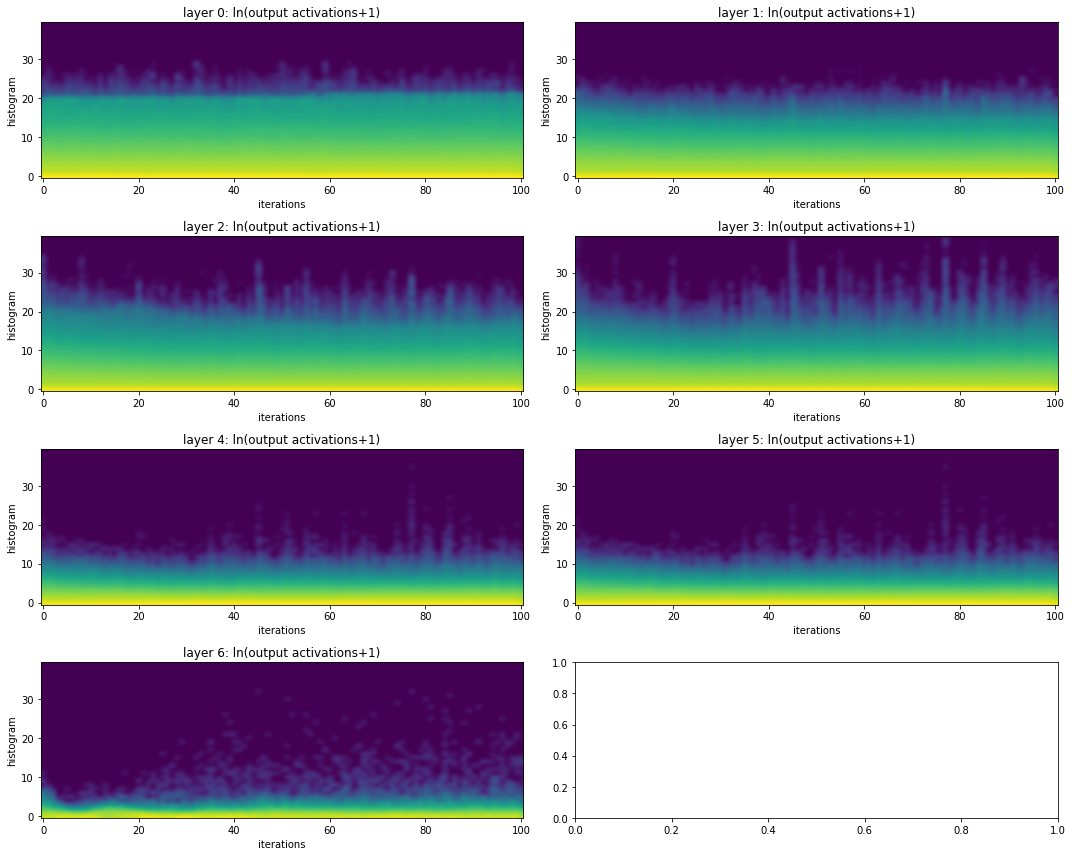

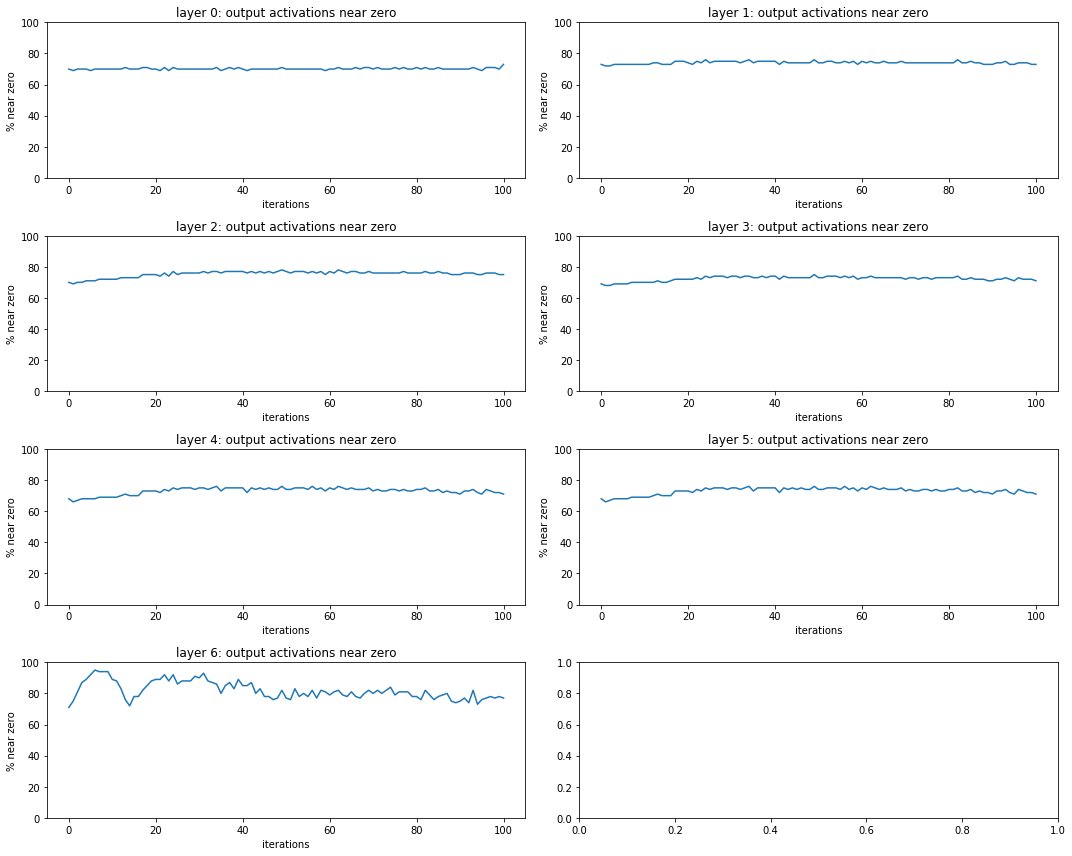

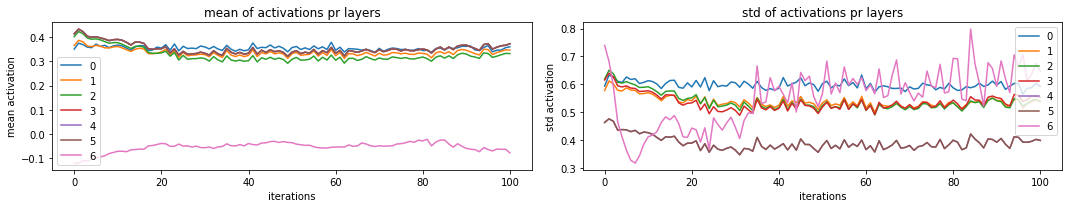

In [17]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=nn.ReLU )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)
                        
with Hooks(mm.model, append_stats) as hooks: 
    learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
    learn.fit(1, opt=Adam(sched,max_lr=2e-4, moms=(0.85,0.95), max_wd = 1e-4), cb_funcs=cbfs)
    plot_layer_stats( hooks )

## LAMB with hooks

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.274159,0.185513,1.969326,0.304000,02:27


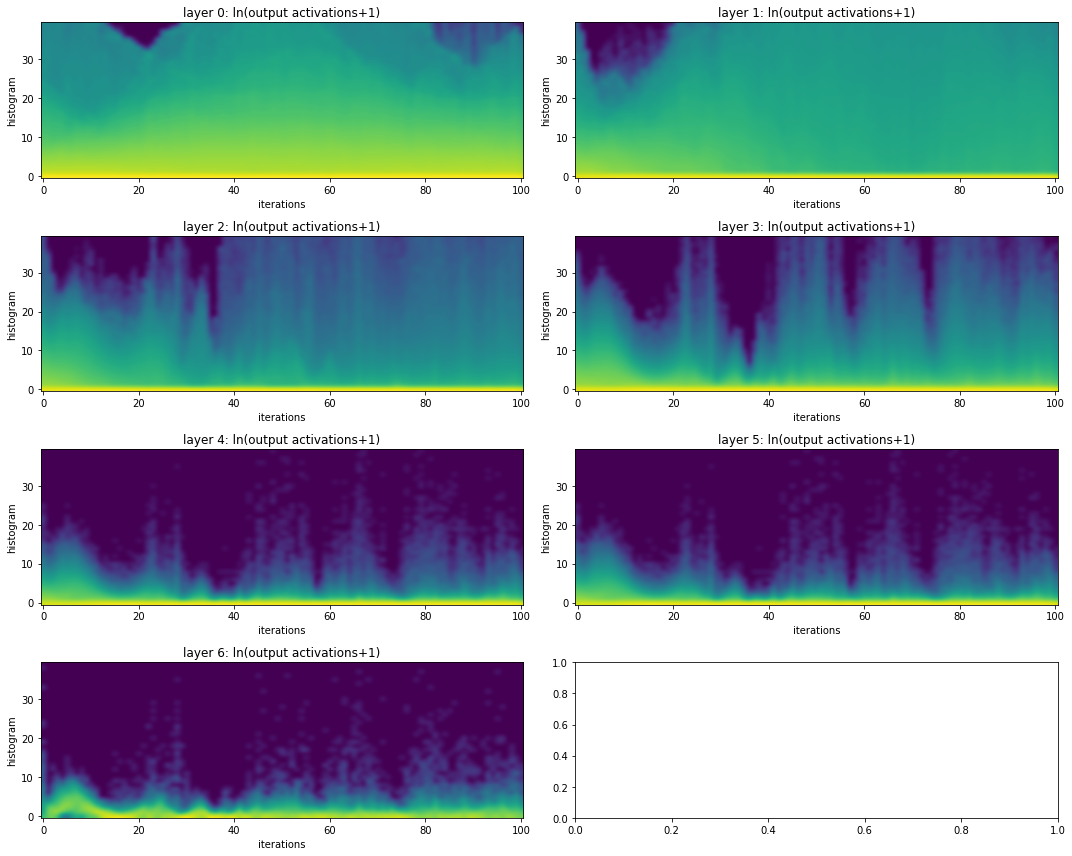

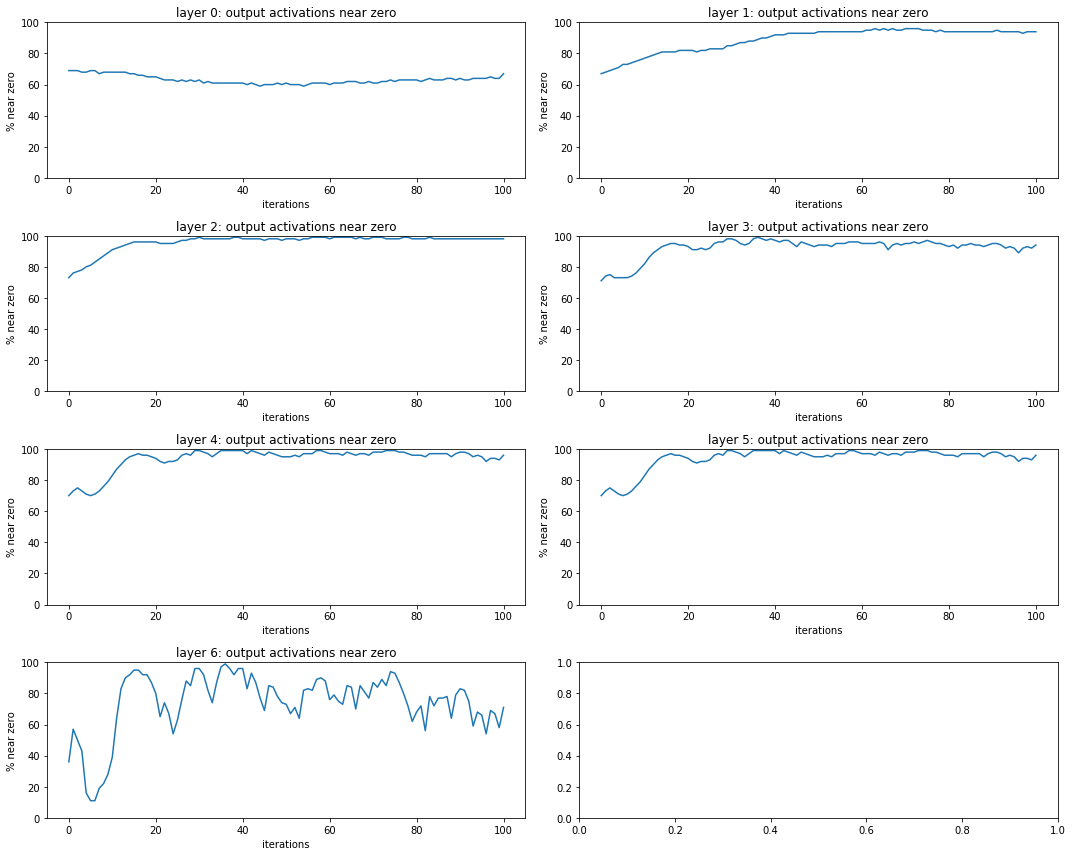

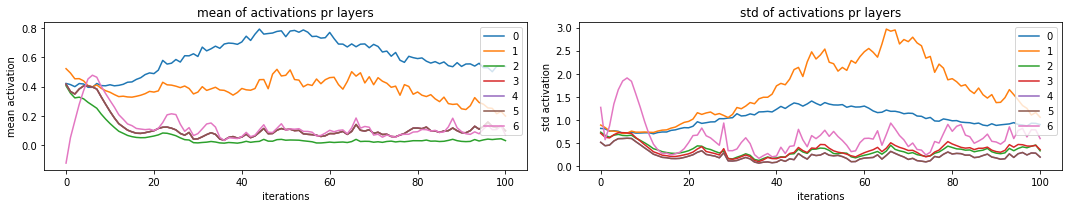

In [18]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=nn.ReLU )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)

with Hooks(mm.model, append_stats) as hooks: 
    learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
    learn.fit(1, opt=LAMB(sched,max_lr=1e-2, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs )
    plot_layer_stats( hooks )